# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

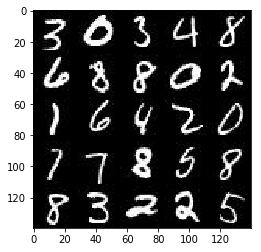

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

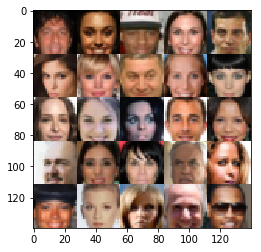

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='inputs_real')
    inputs_z = tf.placeholder(tf.float32,shape=(None,z_dim),name='inputs_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    
    return inputs_real, inputs_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.2
        #input layer 28 * 28 * 3
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        bn3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4*256
        
        #Flatten
        flat = tf.reshape(relu3,(-1,4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        
    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [48]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=(not is_train)):
        alpha = 0.2
        
        # Fully connected layer
        x1 = tf.layers.dense(z, 6*6*256)
        

        # Reshape it to start conv
        x1 = tf.reshape(x1,(-1,6,6,256))
        
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 6x6x512 now

        x2 = tf.layers.conv2d_transpose(x1,128,4,strides=2,padding='valid')        
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        
        x2 = tf.layers.conv2d_transpose(x2,64,5,strides=1,padding='same')        
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256

        logits = tf.layers.conv2d_transpose(x2,out_channel_dim,2,strides=2,padding='valid')
        # 28*28*channel_dim now

        logits = tf.layers.dropout(logits,rate=0.2)
        out = tf.tanh(logits)    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [49]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #print(out_channel_dim)
    g_model = generator(input_z,out_channel_dim=out_channel_dim)
    #print(g_model.shape)
    d_model_real,d_logits_real = discriminator(input_real)
    #print(input_real.shape)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [50]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [51]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [52]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph();
    # print(z_dim)
    out_channel_dim = data_shape[3]
    
    input_real,input_z,lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    
    d_loss, g_loss = model_loss(input_real,input_z,data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss,g_loss,learning_rate,beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1,1,size=(72,z_dim))
    samples,losses = [],[]
    
    # TODO: Train Model
    steps = 0
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):            
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # sample random noise for Generator
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                # Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images , input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every ==0:
                    train_loss_d = d_loss.eval({input_z: batch_z,input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1,epochs),
                          "Discriminator loss:{:.4f}...".format(train_loss_d),
                          "Generator loss:{:.4f}".format(train_loss_g))
                    
                if steps % show_every ==0:
                    show_generator_output(sess,80,input_z,out_channel_dim=out_channel_dim,image_mode=data_image_mode)
        saver.save(sess,'./checkpoints/generator.ckpt')            
        
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator loss:0.0372... Generator loss:4.2410
Epoch 1/2... Discriminator loss:0.0108... Generator loss:5.0573
Epoch 1/2... Discriminator loss:0.0064... Generator loss:5.4969
Epoch 1/2... Discriminator loss:0.0085... Generator loss:5.9154
Epoch 1/2... Discriminator loss:0.0078... Generator loss:5.3124
Epoch 1/2... Discriminator loss:0.0074... Generator loss:5.4231
Epoch 1/2... Discriminator loss:0.0096... Generator loss:5.2145
Epoch 1/2... Discriminator loss:0.0048... Generator loss:5.9410
Epoch 1/2... Discriminator loss:0.0212... Generator loss:4.3238
Epoch 1/2... Discriminator loss:0.0059... Generator loss:5.9798


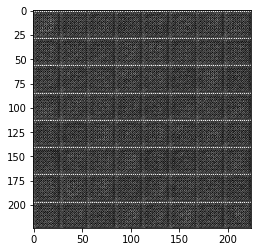

Epoch 1/2... Discriminator loss:0.0830... Generator loss:23.2099
Epoch 1/2... Discriminator loss:1.2015... Generator loss:1.0302
Epoch 1/2... Discriminator loss:0.2380... Generator loss:5.6981
Epoch 1/2... Discriminator loss:0.8895... Generator loss:1.2207
Epoch 1/2... Discriminator loss:0.5280... Generator loss:1.5337
Epoch 1/2... Discriminator loss:0.4469... Generator loss:1.5682
Epoch 1/2... Discriminator loss:0.4296... Generator loss:2.8050
Epoch 1/2... Discriminator loss:0.4525... Generator loss:2.2573
Epoch 1/2... Discriminator loss:0.9535... Generator loss:0.8361
Epoch 1/2... Discriminator loss:0.6990... Generator loss:1.5053


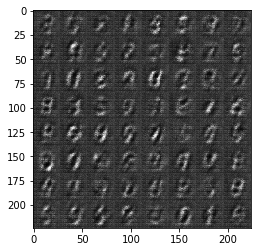

Epoch 1/2... Discriminator loss:1.6013... Generator loss:0.3708
Epoch 1/2... Discriminator loss:0.5823... Generator loss:2.0089
Epoch 1/2... Discriminator loss:0.7690... Generator loss:0.8377
Epoch 1/2... Discriminator loss:0.6172... Generator loss:2.3491
Epoch 1/2... Discriminator loss:0.8794... Generator loss:3.2326
Epoch 1/2... Discriminator loss:0.4845... Generator loss:1.4039
Epoch 1/2... Discriminator loss:0.5985... Generator loss:3.3532
Epoch 1/2... Discriminator loss:0.8689... Generator loss:0.7054
Epoch 1/2... Discriminator loss:0.5651... Generator loss:3.1256
Epoch 1/2... Discriminator loss:0.3052... Generator loss:2.3645


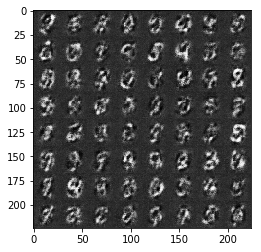

Epoch 1/2... Discriminator loss:1.5694... Generator loss:5.2811
Epoch 1/2... Discriminator loss:0.2975... Generator loss:2.6303
Epoch 1/2... Discriminator loss:0.2720... Generator loss:2.1049
Epoch 1/2... Discriminator loss:0.2309... Generator loss:2.7460
Epoch 1/2... Discriminator loss:0.3051... Generator loss:2.9119
Epoch 1/2... Discriminator loss:0.3217... Generator loss:2.5030
Epoch 1/2... Discriminator loss:0.4892... Generator loss:1.1877
Epoch 1/2... Discriminator loss:0.2432... Generator loss:2.8930
Epoch 1/2... Discriminator loss:0.3339... Generator loss:1.9845
Epoch 1/2... Discriminator loss:0.4279... Generator loss:1.4047


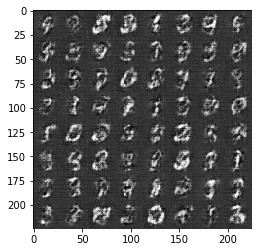

Epoch 1/2... Discriminator loss:0.3488... Generator loss:2.3285
Epoch 1/2... Discriminator loss:0.3448... Generator loss:1.6051
Epoch 1/2... Discriminator loss:0.3589... Generator loss:1.9620
Epoch 1/2... Discriminator loss:0.6003... Generator loss:1.0347
Epoch 1/2... Discriminator loss:0.4941... Generator loss:3.1239
Epoch 1/2... Discriminator loss:0.2337... Generator loss:2.4188
Epoch 2/2... Discriminator loss:0.3354... Generator loss:1.8436
Epoch 2/2... Discriminator loss:0.3217... Generator loss:2.1364
Epoch 2/2... Discriminator loss:0.2738... Generator loss:1.9892
Epoch 2/2... Discriminator loss:0.3231... Generator loss:1.8455


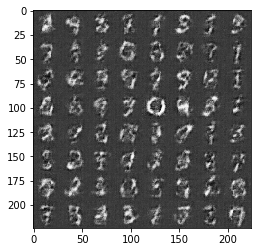

Epoch 2/2... Discriminator loss:0.3237... Generator loss:1.7266
Epoch 2/2... Discriminator loss:0.2254... Generator loss:2.3702
Epoch 2/2... Discriminator loss:0.2680... Generator loss:3.0753
Epoch 2/2... Discriminator loss:0.2608... Generator loss:2.0969
Epoch 2/2... Discriminator loss:0.1929... Generator loss:2.5952
Epoch 2/2... Discriminator loss:2.4054... Generator loss:0.1496
Epoch 2/2... Discriminator loss:0.3389... Generator loss:1.7896
Epoch 2/2... Discriminator loss:0.2643... Generator loss:2.0255
Epoch 2/2... Discriminator loss:0.1771... Generator loss:2.5151
Epoch 2/2... Discriminator loss:0.1583... Generator loss:2.7116


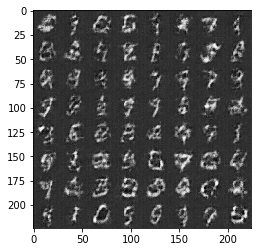

Epoch 2/2... Discriminator loss:0.1767... Generator loss:2.4691
Epoch 2/2... Discriminator loss:0.1924... Generator loss:2.1257
Epoch 2/2... Discriminator loss:0.1422... Generator loss:2.7430
Epoch 2/2... Discriminator loss:0.1270... Generator loss:3.1375
Epoch 2/2... Discriminator loss:0.8532... Generator loss:0.7298
Epoch 2/2... Discriminator loss:0.3369... Generator loss:1.7878
Epoch 2/2... Discriminator loss:0.2156... Generator loss:2.3258
Epoch 2/2... Discriminator loss:0.2538... Generator loss:2.0239
Epoch 2/2... Discriminator loss:0.1936... Generator loss:2.3052
Epoch 2/2... Discriminator loss:0.1568... Generator loss:2.4513


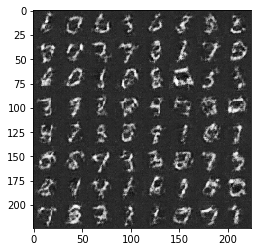

Epoch 2/2... Discriminator loss:0.1697... Generator loss:2.3719
Epoch 2/2... Discriminator loss:0.1428... Generator loss:2.6390
Epoch 2/2... Discriminator loss:0.1535... Generator loss:2.5253
Epoch 2/2... Discriminator loss:0.2030... Generator loss:2.1548
Epoch 2/2... Discriminator loss:0.1592... Generator loss:2.6330
Epoch 2/2... Discriminator loss:0.1423... Generator loss:2.7489
Epoch 2/2... Discriminator loss:0.1911... Generator loss:2.0640
Epoch 2/2... Discriminator loss:0.1723... Generator loss:2.2376
Epoch 2/2... Discriminator loss:0.2166... Generator loss:2.0900
Epoch 2/2... Discriminator loss:0.1205... Generator loss:2.9505


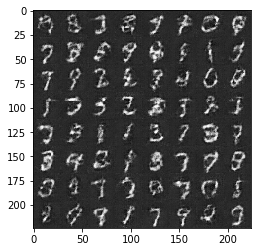

Epoch 2/2... Discriminator loss:3.0297... Generator loss:0.6568
Epoch 2/2... Discriminator loss:0.4187... Generator loss:1.6665
Epoch 2/2... Discriminator loss:0.3272... Generator loss:1.9058
Epoch 2/2... Discriminator loss:0.3241... Generator loss:1.7361
Epoch 2/2... Discriminator loss:0.2537... Generator loss:1.8499
Epoch 2/2... Discriminator loss:0.2735... Generator loss:1.8767
Epoch 2/2... Discriminator loss:0.2441... Generator loss:1.8900
Epoch 2/2... Discriminator loss:0.1650... Generator loss:2.4318
Epoch 2/2... Discriminator loss:0.1871... Generator loss:2.1868
Epoch 2/2... Discriminator loss:0.1541... Generator loss:2.4923


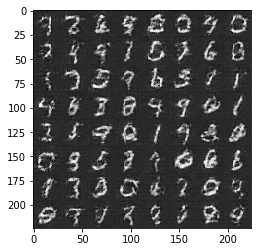

Epoch 2/2... Discriminator loss:0.1725... Generator loss:2.2814
Epoch 2/2... Discriminator loss:0.1881... Generator loss:2.1292
Epoch 2/2... Discriminator loss:0.1316... Generator loss:2.5030


In [53]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator loss:0.1228... Generator loss:2.7145
Epoch 1/1... Discriminator loss:0.0420... Generator loss:4.0567
Epoch 1/1... Discriminator loss:0.0285... Generator loss:4.1132
Epoch 1/1... Discriminator loss:0.0225... Generator loss:4.2566
Epoch 1/1... Discriminator loss:0.0194... Generator loss:4.5551
Epoch 1/1... Discriminator loss:6.1901... Generator loss:0.0046
Epoch 1/1... Discriminator loss:0.1833... Generator loss:6.2990
Epoch 1/1... Discriminator loss:1.0334... Generator loss:0.7918
Epoch 1/1... Discriminator loss:1.0204... Generator loss:0.6637
Epoch 1/1... Discriminator loss:0.8378... Generator loss:0.8453


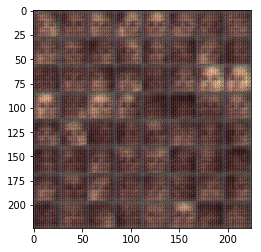

Epoch 1/1... Discriminator loss:0.7958... Generator loss:1.5031
Epoch 1/1... Discriminator loss:0.8671... Generator loss:0.8831
Epoch 1/1... Discriminator loss:0.4780... Generator loss:1.5008
Epoch 1/1... Discriminator loss:0.4149... Generator loss:2.9055
Epoch 1/1... Discriminator loss:0.4570... Generator loss:1.7804
Epoch 1/1... Discriminator loss:0.5288... Generator loss:1.4331
Epoch 1/1... Discriminator loss:0.4438... Generator loss:1.9421
Epoch 1/1... Discriminator loss:1.5965... Generator loss:7.6381
Epoch 1/1... Discriminator loss:1.1704... Generator loss:2.5660
Epoch 1/1... Discriminator loss:1.2893... Generator loss:0.6155


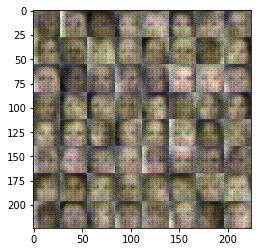

Epoch 1/1... Discriminator loss:0.8248... Generator loss:1.3314
Epoch 1/1... Discriminator loss:0.6385... Generator loss:1.8503
Epoch 1/1... Discriminator loss:0.7051... Generator loss:1.2015
Epoch 1/1... Discriminator loss:0.4095... Generator loss:1.6645
Epoch 1/1... Discriminator loss:0.4631... Generator loss:1.5280
Epoch 1/1... Discriminator loss:0.7246... Generator loss:1.4177
Epoch 1/1... Discriminator loss:0.6333... Generator loss:1.7181
Epoch 1/1... Discriminator loss:0.5619... Generator loss:1.3700
Epoch 1/1... Discriminator loss:0.7924... Generator loss:0.9047
Epoch 1/1... Discriminator loss:0.7058... Generator loss:1.2799


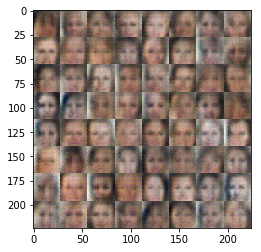

Epoch 1/1... Discriminator loss:0.7398... Generator loss:1.0696
Epoch 1/1... Discriminator loss:0.9201... Generator loss:2.7734
Epoch 1/1... Discriminator loss:0.7334... Generator loss:1.0128
Epoch 1/1... Discriminator loss:1.0083... Generator loss:0.9326
Epoch 1/1... Discriminator loss:0.6343... Generator loss:1.6781
Epoch 1/1... Discriminator loss:1.2090... Generator loss:0.4917
Epoch 1/1... Discriminator loss:0.7265... Generator loss:1.9942
Epoch 1/1... Discriminator loss:0.8051... Generator loss:1.5545
Epoch 1/1... Discriminator loss:0.6711... Generator loss:2.4171
Epoch 1/1... Discriminator loss:0.5603... Generator loss:2.3424


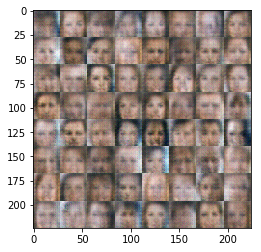

Epoch 1/1... Discriminator loss:0.9431... Generator loss:1.8667
Epoch 1/1... Discriminator loss:0.9029... Generator loss:0.8182
Epoch 1/1... Discriminator loss:0.7655... Generator loss:0.9230
Epoch 1/1... Discriminator loss:0.9879... Generator loss:0.7028
Epoch 1/1... Discriminator loss:1.0969... Generator loss:0.5488
Epoch 1/1... Discriminator loss:0.6233... Generator loss:4.1902
Epoch 1/1... Discriminator loss:0.7110... Generator loss:1.2274
Epoch 1/1... Discriminator loss:0.7708... Generator loss:1.4448
Epoch 1/1... Discriminator loss:0.8234... Generator loss:1.2497
Epoch 1/1... Discriminator loss:1.1011... Generator loss:0.5143


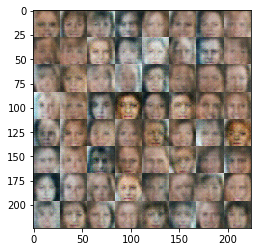

Epoch 1/1... Discriminator loss:0.9843... Generator loss:0.9548
Epoch 1/1... Discriminator loss:0.6464... Generator loss:1.2342
Epoch 1/1... Discriminator loss:0.5568... Generator loss:1.3350
Epoch 1/1... Discriminator loss:1.4966... Generator loss:0.3330
Epoch 1/1... Discriminator loss:0.9576... Generator loss:0.8049
Epoch 1/1... Discriminator loss:0.9401... Generator loss:1.4828
Epoch 1/1... Discriminator loss:0.6561... Generator loss:1.3516
Epoch 1/1... Discriminator loss:0.7318... Generator loss:1.1271
Epoch 1/1... Discriminator loss:0.6600... Generator loss:1.5212
Epoch 1/1... Discriminator loss:0.8824... Generator loss:2.6563


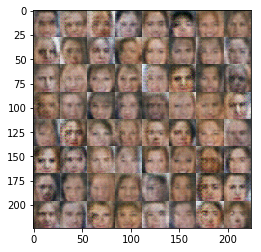

Epoch 1/1... Discriminator loss:0.7174... Generator loss:1.6752
Epoch 1/1... Discriminator loss:0.6823... Generator loss:1.8812
Epoch 1/1... Discriminator loss:0.8210... Generator loss:0.8421
Epoch 1/1... Discriminator loss:0.9081... Generator loss:1.5570
Epoch 1/1... Discriminator loss:0.6861... Generator loss:1.0177
Epoch 1/1... Discriminator loss:0.9614... Generator loss:0.6567
Epoch 1/1... Discriminator loss:0.9428... Generator loss:0.7264
Epoch 1/1... Discriminator loss:0.6382... Generator loss:1.6388
Epoch 1/1... Discriminator loss:0.6750... Generator loss:1.2837
Epoch 1/1... Discriminator loss:0.6235... Generator loss:2.6372


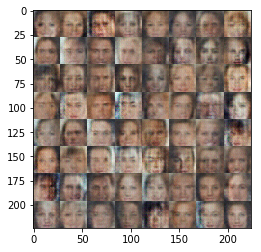

Epoch 1/1... Discriminator loss:1.3832... Generator loss:0.4012
Epoch 1/1... Discriminator loss:0.8150... Generator loss:2.0456
Epoch 1/1... Discriminator loss:0.5446... Generator loss:1.7780
Epoch 1/1... Discriminator loss:0.8881... Generator loss:0.7027
Epoch 1/1... Discriminator loss:0.6286... Generator loss:1.1295
Epoch 1/1... Discriminator loss:1.1223... Generator loss:2.5012
Epoch 1/1... Discriminator loss:0.7247... Generator loss:1.3320
Epoch 1/1... Discriminator loss:0.4986... Generator loss:1.3989
Epoch 1/1... Discriminator loss:1.4853... Generator loss:0.3934
Epoch 1/1... Discriminator loss:0.8327... Generator loss:0.9740


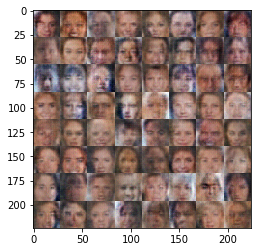

Epoch 1/1... Discriminator loss:0.4044... Generator loss:1.9692
Epoch 1/1... Discriminator loss:0.6991... Generator loss:2.4131
Epoch 1/1... Discriminator loss:0.4737... Generator loss:1.5143
Epoch 1/1... Discriminator loss:0.8369... Generator loss:0.8812
Epoch 1/1... Discriminator loss:0.6849... Generator loss:1.0819
Epoch 1/1... Discriminator loss:0.7294... Generator loss:0.8761
Epoch 1/1... Discriminator loss:0.8760... Generator loss:0.7650
Epoch 1/1... Discriminator loss:0.6769... Generator loss:1.1177
Epoch 1/1... Discriminator loss:0.8383... Generator loss:0.7428
Epoch 1/1... Discriminator loss:0.5369... Generator loss:1.2655


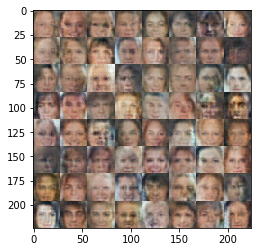

Epoch 1/1... Discriminator loss:0.7070... Generator loss:0.8949
Epoch 1/1... Discriminator loss:0.6377... Generator loss:1.4626
Epoch 1/1... Discriminator loss:0.5560... Generator loss:1.2945
Epoch 1/1... Discriminator loss:0.2989... Generator loss:2.8724
Epoch 1/1... Discriminator loss:1.0720... Generator loss:2.2158
Epoch 1/1... Discriminator loss:0.7842... Generator loss:2.3765
Epoch 1/1... Discriminator loss:1.4362... Generator loss:3.4021
Epoch 1/1... Discriminator loss:0.7129... Generator loss:0.9308
Epoch 1/1... Discriminator loss:0.9011... Generator loss:0.6307
Epoch 1/1... Discriminator loss:0.2855... Generator loss:2.1884


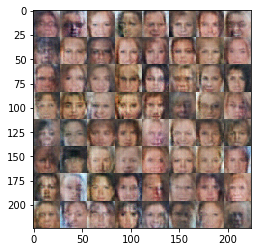

Epoch 1/1... Discriminator loss:0.7041... Generator loss:0.8368
Epoch 1/1... Discriminator loss:0.7238... Generator loss:0.9290
Epoch 1/1... Discriminator loss:0.4301... Generator loss:1.6850
Epoch 1/1... Discriminator loss:2.1696... Generator loss:0.2096
Epoch 1/1... Discriminator loss:0.4083... Generator loss:2.9946
Epoch 1/1... Discriminator loss:0.3553... Generator loss:4.4590
Epoch 1/1... Discriminator loss:0.3149... Generator loss:1.7055
Epoch 1/1... Discriminator loss:0.2592... Generator loss:4.5016
Epoch 1/1... Discriminator loss:0.5553... Generator loss:6.5767
Epoch 1/1... Discriminator loss:0.4346... Generator loss:2.9956


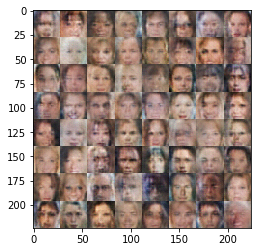

Epoch 1/1... Discriminator loss:0.9788... Generator loss:0.5818
Epoch 1/1... Discriminator loss:0.0699... Generator loss:6.0644
Epoch 1/1... Discriminator loss:0.5212... Generator loss:4.7206
Epoch 1/1... Discriminator loss:1.2876... Generator loss:4.2370
Epoch 1/1... Discriminator loss:0.1324... Generator loss:3.3368
Epoch 1/1... Discriminator loss:0.9062... Generator loss:0.6619
Epoch 1/1... Discriminator loss:0.0594... Generator loss:5.2633
Epoch 1/1... Discriminator loss:0.1143... Generator loss:2.9570
Epoch 1/1... Discriminator loss:0.1404... Generator loss:4.3858
Epoch 1/1... Discriminator loss:0.2411... Generator loss:3.2828


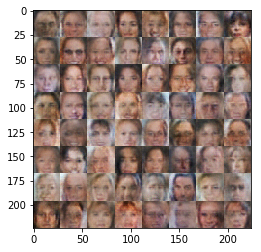

Epoch 1/1... Discriminator loss:0.2005... Generator loss:5.7755
Epoch 1/1... Discriminator loss:0.0878... Generator loss:9.5694
Epoch 1/1... Discriminator loss:0.3461... Generator loss:4.9527
Epoch 1/1... Discriminator loss:0.3812... Generator loss:1.3896
Epoch 1/1... Discriminator loss:0.0647... Generator loss:4.1366
Epoch 1/1... Discriminator loss:0.2151... Generator loss:5.1538
Epoch 1/1... Discriminator loss:0.3955... Generator loss:1.4109
Epoch 1/1... Discriminator loss:0.3895... Generator loss:1.4444
Epoch 1/1... Discriminator loss:0.7966... Generator loss:0.9945
Epoch 1/1... Discriminator loss:0.5009... Generator loss:1.1037


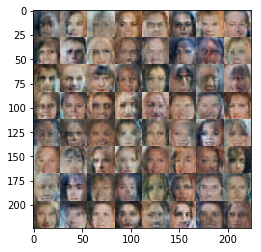

Epoch 1/1... Discriminator loss:1.8691... Generator loss:0.2203
Epoch 1/1... Discriminator loss:0.0985... Generator loss:5.8637
Epoch 1/1... Discriminator loss:0.1243... Generator loss:2.8831
Epoch 1/1... Discriminator loss:0.1772... Generator loss:10.1914
Epoch 1/1... Discriminator loss:0.0327... Generator loss:6.4304
Epoch 1/1... Discriminator loss:0.0663... Generator loss:3.4538
Epoch 1/1... Discriminator loss:0.0383... Generator loss:7.3082
Epoch 1/1... Discriminator loss:0.5006... Generator loss:7.4766
Epoch 1/1... Discriminator loss:0.0694... Generator loss:5.3024
Epoch 1/1... Discriminator loss:0.2378... Generator loss:2.1963


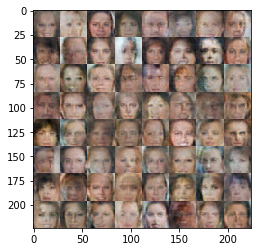

Epoch 1/1... Discriminator loss:0.1242... Generator loss:3.2735
Epoch 1/1... Discriminator loss:0.1070... Generator loss:4.6903
Epoch 1/1... Discriminator loss:1.8397... Generator loss:0.2058
Epoch 1/1... Discriminator loss:0.7920... Generator loss:5.3188
Epoch 1/1... Discriminator loss:0.1342... Generator loss:5.1103
Epoch 1/1... Discriminator loss:1.1525... Generator loss:0.4880
Epoch 1/1... Discriminator loss:0.3587... Generator loss:1.6683
Epoch 1/1... Discriminator loss:0.0521... Generator loss:3.6957
Epoch 1/1... Discriminator loss:0.0590... Generator loss:5.5757
Epoch 1/1... Discriminator loss:0.2898... Generator loss:2.0335


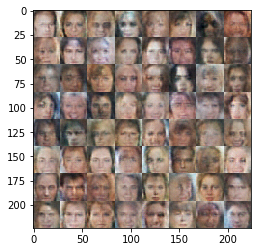

Epoch 1/1... Discriminator loss:0.0221... Generator loss:9.1545
Epoch 1/1... Discriminator loss:0.2617... Generator loss:6.0359
Epoch 1/1... Discriminator loss:0.3094... Generator loss:1.6667
Epoch 1/1... Discriminator loss:0.0592... Generator loss:7.8240
Epoch 1/1... Discriminator loss:0.0350... Generator loss:4.9715
Epoch 1/1... Discriminator loss:0.0221... Generator loss:7.5038
Epoch 1/1... Discriminator loss:0.1399... Generator loss:2.5225
Epoch 1/1... Discriminator loss:1.8441... Generator loss:6.9591


In [54]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.